In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib as plt
import stock_utils as su
import trader as tr
import signaller as sg

from sklearn.externals import joblib

%matplotlib inline

## Choose a ticker symbol and generate a dataset with selected new features for it

In [2]:
#create a dataset for AAPL
rs = 42 # random state
tickers = ['AAPL', 'XOM']
symbol = tickers[0]
window = 5
look_ahead = 1

start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2017, 10, 30)

## Load saved models

In [3]:
import os
model_filenames = []
for file in os.listdir('models'):
    if file.endswith('.pkl'):
        model_filenames.append(file)

estimators = []
for filename in model_filenames:
    estimators.append(joblib.load('models/{0}'.format(filename)))

## Load stock data and calculate predictions

In [4]:
dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

#calculate the predicted prices
pred = su.calculate_predictions_for_dataset(dataset=dataset, estimators=estimators, plot_and_print=False)

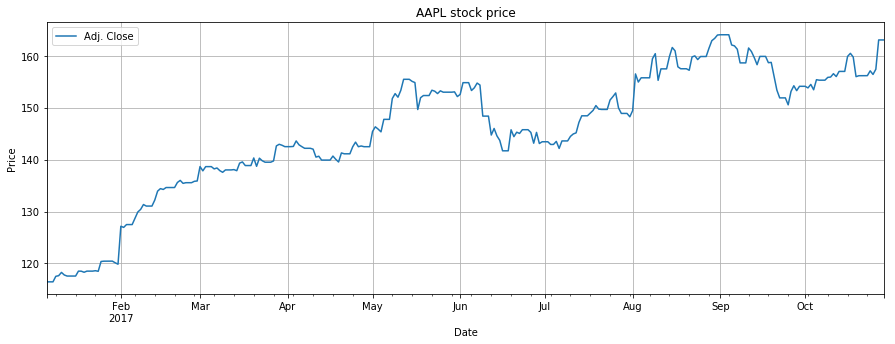

In [5]:
data_frame = dataset[['Adj. Close']]
ax = data_frame.plot(figsize=(15,5), grid=True, title='{0} stock price'.format(symbol))

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

## Calculate trade signals based on the predictions

In [6]:
#add the predicted prices to the dataset
dataset['Predicted Price'] = pred

#price variation in percentage which can inform trade decisions
delta = 0.01

signaller_params = {'delta' : delta}

#calculate trade signals based on different indicators and add those signals to the dataframe
signaller = sg.Signaller(signaller_params)

dataset = signaller.calculate_trade_signal(dataset)

dataset.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price,Predicted Price,Current RM Signal,Current BB Signal,Current Signal,RM Signal,Percentage Signal,BB Signal,Trade Signal
2017-01-06,115.337596,116.700551,115.031425,116.453639,0.011148,115.128215,113.581518,116.674912,0.015153,116.453639,116.310274,-1,0,-1,0,0,0,0
2017-01-07,115.337596,116.700551,115.031425,116.453639,0.000000,115.475867,113.638947,117.312787,0.015153,116.453639,116.189075,0,0,0,0,0,0,0
2017-01-08,115.337596,116.700551,115.031425,116.453639,0.000000,115.823519,114.049355,117.597684,0.015153,117.520300,116.180980,0,0,0,0,0,0,0
2017-01-09,116.493145,117.954865,116.483269,117.520300,0.009160,116.410183,114.743800,118.076566,0.025599,117.638817,117.482460,0,0,0,0,0,0,0
2017-01-10,117.303017,117.905483,116.838822,117.638817,0.001008,116.904007,115.667780,118.140234,0.021439,118.270913,117.499500,0,0,0,0,0,0,0


In [7]:
dataset.describe()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price,Predicted Price,Current RM Signal,Current BB Signal,Current Signal,RM Signal,Percentage Signal,BB Signal,Trade Signal
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.0,297.000000,297.000000,297.0,297.0,297.000000
mean,145.540919,146.442411,144.643754,145.613314,0.001215,145.292590,143.179387,147.405794,0.005861,145.782561,145.558618,-0.087542,0.0,-0.087542,-0.040404,0.0,0.0,-0.040404
std,12.180785,12.286513,11.897156,12.051456,0.009375,12.171105,11.848690,12.703893,0.019750,11.993385,12.060917,0.492250,0.0,0.492250,0.281856,0.0,0.0,0.281856
min,115.337596,116.700551,115.031425,116.453639,-0.038777,115.128215,113.581518,116.674912,-0.064684,116.453639,116.180980,-1.000000,0.0,-1.000000,-1.000000,0.0,0.0,-1.000000
25%,139.857880,140.353830,138.756871,139.500796,-0.001690,139.286546,137.839899,140.385337,-0.002959,139.500796,139.493217,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
50%,145.571223,146.903945,144.792512,145.997622,0.000000,146.035469,143.451342,148.810419,0.006732,146.315148,145.904257,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
75%,154.970000,155.787899,154.094768,155.300000,0.003877,154.481201,152.897230,156.985543,0.016250,155.300000,155.180617,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
max,164.800000,164.940000,163.630000,164.050000,0.060981,164.040000,163.995279,167.359194,0.063700,166.720000,164.106616,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000


## Define trading strategies based on the generated trade signals

In [8]:
#risk behaviour levels for buying stocks: the higher the value, the higher the confidence that the signal is correct
buy_risk_levels = {'high' : 1, 'moderate' : 2, 'low' : 3}

#risk behaviour levels for selling stocks: the lower the value, the higher the confidence that the signal is correct
sell_risk_levels = {'low' : -3, 'moderate' : -2, 'high' : -1}

debug_flag = False

initial_funds = 100000

pred_trader_configurations = [\
                         #balanced trader
                         {'name' : 'Prediction Balanced Trader', \
                          'buy_risk' : buy_risk_levels['moderate'], \
                          'sell_risk' : sell_risk_levels['moderate'], \
                          'use_signal_strength' : False, \
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         },\
                         #bearish trader
                         {'name' : 'Prediction Bearish Trader', \
                          'buy_risk' : buy_risk_levels['low'], \
                          'sell_risk' : sell_risk_levels['high'], \
                          'use_signal_strength' : False,
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         },\
                         #bullish trader
                         {'name' : 'Prediction Bullish Trader', \
                          'buy_risk' : buy_risk_levels['high'], \
                          'sell_risk' : sell_risk_levels['low'], \
                          'use_signal_strength' : False, \
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         }\
                        ]

normal_trader_configurations = [\
                         #balanced trader
                         {'name' : 'Normal Balanced Trader', \
                          'buy_risk' : buy_risk_levels['moderate'], \
                          'sell_risk' : sell_risk_levels['moderate'], \
                          'use_signal_strength' : False, \
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         },\
                         #bearish trader
                         {'name' : 'Normal Bearish Trader', \
                          'buy_risk' : buy_risk_levels['low'], \
                          'sell_risk' : sell_risk_levels['high'], \
                          'use_signal_strength' : False,
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         },\
                         #bullish trader
                         {'name' : 'Normal Bullish Trader', \
                          'buy_risk' : buy_risk_levels['high'], \
                          'sell_risk' : sell_risk_levels['low'], \
                          'use_signal_strength' : False, \
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         }\
                        ]

## Find the best trading strategy for the given stock data

In [9]:
# highest_profit = -100
# best_trader = None

# first run trading based on predictions
pred_trade_df = dataset[['Adj. Close', 'Trade Signal']]

pred_profits = []

for config in pred_trader_configurations:
    
    trader = tr.Trader(config)
    trader.trade(pred_trade_df)

    pred_profits.append(trader.profit)
    
#     if trader.profit > highest_profit:
#         highest_profit = trader.profit
#         best_trader = config['name']

#then run trading based just on current data
normal_trade_df = dataset[['Adj. Close', 'Current Signal']]

normal_profits = []

for config in normal_trader_configurations:
    trader = tr.Trader(config)
    trader.trade(normal_trade_df)
    
    normal_profits.append(trader.profit)
    
#     if trader.profit > highest_profit:
#         highest_profit = trader.profit
#         best_trader = config['name']
    
# print('Best trader for this {0} stock market data is : {1}'.format(symbol, best_trader))

Prediction Balanced Trader starts trading
Prediction Balanced Trader enters position by buying 400.0 stocks at 116.45$ and has 53371.96$ left to invest
After 0 transactions, Prediction Balanced Trader has 400.0 stocks and 53371.96$ left in funds
Prediction Balanced Trader exits his position with a profit of 0.00%

Prediction Bearish Trader starts trading
Prediction Bearish Trader enters position by buying 400.0 stocks at 116.45$ and has 53371.96$ left to invest
After 4 transactions, Prediction Bearish Trader has 0.0 stocks and 103354.65$ left in funds
Prediction Bearish Trader exits his position with a profit of 3.35%

Prediction Bullish Trader starts trading
Prediction Bullish Trader enters position by buying 400.0 stocks at 116.45$ and has 53371.96$ left to invest
After 3 transactions, Prediction Bullish Trader has 700.0 stocks and 11623.84$ left in funds
Prediction Bullish Trader exits his position with a profit of 25.64%

Normal Balanced Trader starts trading
Normal Balanced Trader

In [10]:
# profits = np.array([normal_profits, pred_profits]).T
# profits_df = pd.DataFrame(profits, columns=['Normal Traders', 'Prediction Traders'])
# profits_df.head()

## Let's test for another stock

In [11]:
symbol = tickers[1]

dataset2 = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

data2 = dataset2.drop(labels=['Future Price'], axis=1)
target2 = dataset2['Future Price']

dataset2.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2017-01-06,85.544013,85.727067,84.609474,85.264615,-0.000565,86.463137,84.178922,88.747352,-0.026296,85.264615
2017-01-07,85.544013,85.727067,84.609474,85.264615,0.000000,86.002611,83.911050,88.094173,-0.026296,85.264615
2017-01-08,85.544013,85.727067,84.609474,85.264615,0.000000,85.542086,84.354322,86.729850,-0.026296,83.857990
2017-01-09,84.994851,84.994851,83.385903,83.857990,-0.016497,84.992924,83.723343,86.262505,-0.031705,82.788569
2017-01-10,83.983237,84.118119,82.769300,82.788569,-0.012753,84.488081,82.231009,86.745152,-0.029588,83.636398


In [12]:
dataset2.describe()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,80.566963,80.928085,80.097470,80.506033,-0.000046,80.524151,79.728086,81.320216,-0.000587,80.500227
std,1.680553,1.683576,1.632760,1.690517,0.006023,1.688006,1.691823,1.830722,0.012342,1.677025
min,76.180000,76.450000,76.050000,76.100000,-0.020191,76.384000,75.219393,76.736663,-0.031705,76.100000
25%,79.784722,80.157548,79.343217,79.696421,-0.002328,79.732565,78.995405,80.403016,-0.008326,79.696421
50%,80.490000,80.805087,79.985000,80.451884,0.000000,80.453535,79.623986,81.248512,-0.000244,80.451884
75%,81.630000,81.911321,81.138668,81.515183,0.002812,81.410207,80.715313,82.290897,0.007219,81.515183
max,85.544013,85.727067,84.609474,85.264615,0.020905,86.463137,84.354322,88.747352,0.033082,85.264615


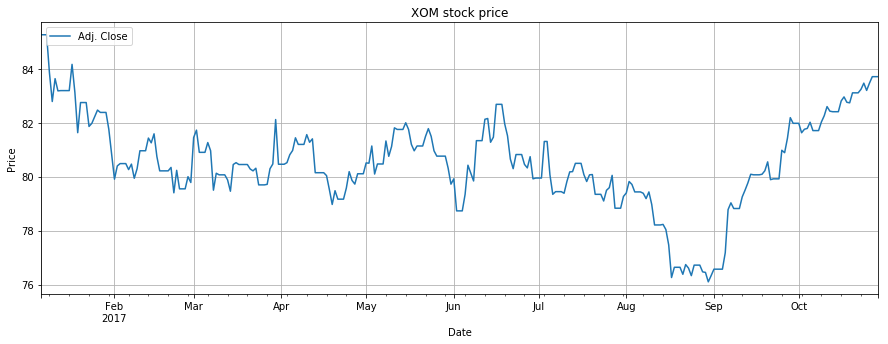

In [13]:
data_frame = data2[['Adj. Close']]

ax = data_frame.plot(figsize=(15,5), grid=True, title='{0} stock price'.format(symbol))

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

In [14]:
dataset2 = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

pred2 = su.calculate_predictions_for_dataset(dataset=dataset2, estimators=estimators, plot_and_print=False)

dataset2['Predicted Price'] = pred2

dataset2 = signaller.calculate_trade_signal(dataset2)

highest_profit = -100
best_trader = None

# first run trading based on predictions
pred_dataset2_df = dataset2[['Adj. Close', 'Trade Signal']]

for config in pred_trader_configurations:
    trader = tr.Trader(config)
    trader.trade(pred_dataset2_df)
    
    pred_profits.append(trader.profit)
    
#     if trader.profit > highest_profit:
#         highest_profit = trader.profit
#         best_trader = config['name']

# then run trading based only on current data
normal_dataset2_df = dataset2[['Adj. Close', 'Current Signal']]

for config in normal_trader_configurations:
    trader = tr.Trader(config)
    trader.trade(normal_dataset2_df)
    
    normal_profits.append(trader.profit)
    
#     if trader.profit > highest_profit:
#         highest_profit = trader.profit
#         best_trader = config['name']
    
# print('Best trader for this {0} stock market data is : {1}'.format(symbol, best_trader))

Prediction Balanced Trader starts trading
Prediction Balanced Trader enters position by buying 500.0 stocks at 85.26$ and has 57325.06$ left to invest
After 0 transactions, Prediction Balanced Trader has 500.0 stocks and 57325.06$ left in funds
Prediction Balanced Trader exits his position with a profit of 0.00%

Prediction Bearish Trader starts trading
Prediction Bearish Trader enters position by buying 500.0 stocks at 85.26$ and has 57325.06$ left to invest
After 5 transactions, Prediction Bearish Trader has 0.0 stocks and 98291.00$ left in funds
Prediction Bearish Trader exits his position with a profit of -1.71%

Prediction Bullish Trader starts trading
Prediction Bullish Trader enters position by buying 500.0 stocks at 85.26$ and has 57325.06$ left to invest
After 7 transactions, Prediction Bullish Trader has 1200.0 stocks and 404.98$ left in funds
Prediction Bullish Trader exits his position with a profit of 0.76%

Normal Balanced Trader starts trading
Normal Balanced Trader ente

In [15]:
profits = np.array([normal_profits, pred_profits]).T
profits_df = pd.DataFrame(profits, columns=['Normal Traders', 'Prediction Traders'])
profits_df[:6]

,Normal Traders,Prediction Traders
0,0.000000,0.000000
1,2.415916,3.354645
2,22.708312,25.644708
3,0.000000,0.000000
4,-2.009398,-1.708995
5,0.370896,0.756528


In [18]:
print('Normal traders mean profit: {0:.2f}%'.format(profits_df['Normal Traders'].mean()))
print('Prediction traders mean profit: {0:.2f}%'.format(profits_df['Prediction Traders'].mean()))

Normal traders mean profit: 3.91%
Prediction traders mean profit: 4.67%
